In [4]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns
import cartopy as cy
import cartopy.crs as ccrs
from read_pangeo import read_pangeo
from importcmip import aodh
import s3fs
xr.set_options(display_style='html')
import intake
import cftime
from netCDF4 import Dataset
from matplotlib.colors import LogNorm
import matplotlib.path as mpath
from matplotlib import rc,animation

from IPython import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
path = 'historical20002014_AR_detection.nc'
ar = xr.open_dataset(path)

In [26]:

from importcmip import aod245, aodh
from aod_correction import bias_correction

histo = aodh['od550aer'].values
ssp245 = aod245['od550aer'].values
b245 = bias_correction(histo,ssp245, '245')
aodh['od550aer'] = (['time','lat','lon'], b245[0]) #b245[0] = historical

/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5647: RuntimeWarning: divide by zero encountered in divide
  return pow(qsk/(1.0-qsk), 1.0/s)
/home/jovyan/Tjaernoe2022-group5/notebooks/Lea/aod_correction.py:42: RuntimeWarning: invalid value encountered in multiply
  loc_pm = delta_loc*loc_qm


In [27]:
# merge datasets
cmh = read_pangeo(2000, 2014, 'historical')
dh = cmh.merge(aodh['od550aer'])

arc = dh.sel(lat = slice(50,90))
ant =dh.sel(lat = slice(-90,-50))


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [28]:
# mask data within and out of atmospheric rivers
marc = arc.where(ar['ivt'] == True)
mant = ant.where(ar['ivt'] == True)
amarc = arc.where(ar['ivt'] == False)
amant = ant.where(ar['ivt'] == False)

## Arctic

In [48]:
# for frequency plots slice for plev >25000 and integrate over plev
mpl =marc.sel(plev=slice(100000, 25000))
pl =amarc.sel(plev=slice(100000, 25000)).where(arc['va'] > 0)

'''# wind
mplva =-1*mpl['va'].integrate('plev')
plva =-1*pl['va'].integrate('plev')'''

# humidity
mplha =-1*mpl['hus'].integrate('plev')
plha =-1*pl['hus'].integrate('plev')


In [51]:
'''mv = mplva.values.flatten()
mv = mv[~np.isnan(mv)]
v = plva.values.flatten()
v= v[~np.isnan(v)]'''
mha = mplha.values.flatten()
mha = mha[~np.isnan(mha)]
ha = plha.values.flatten()
ha = ha[~np.isnan(ha)]
mcca = mpl['clt'].values.flatten()
mcca = mcca[~np.isnan(mcca)]
cca = pl['clt'].values.flatten()
cca = cca[~np.isnan(cca)]
mta = mpl['tas'].values.flatten()
mta = mta[~np.isnan(mta)]
ta = pl['tas'].values.flatten()
ta = ta[~np.isnan(ta)]
maa = mpl['od550aer'].values.flatten()
maa = maa[~np.isnan(maa)]
aa = pl['od550aer'].values.flatten()
aa = aa[~np.isnan(aa)]
mpa = mpl['pr'].values.flatten()
mpa = mpa[~np.isnan(mpa)]
mpa = mpa[mpa>0.0000024099]
pa = pl['pr'].values.flatten()
pa = pa[~np.isnan(pa)]
pa = pa[pa>0.0000024099] # threshold for averaged precipitation in the sahara in the same unit
mp = mpl['pr'].values.flatten()


array([2.8362540e-05, 2.8362540e-05, 2.8868304e-05, ..., 2.4541007e-06,
       2.4541007e-06, 2.4541007e-06], dtype=float32)

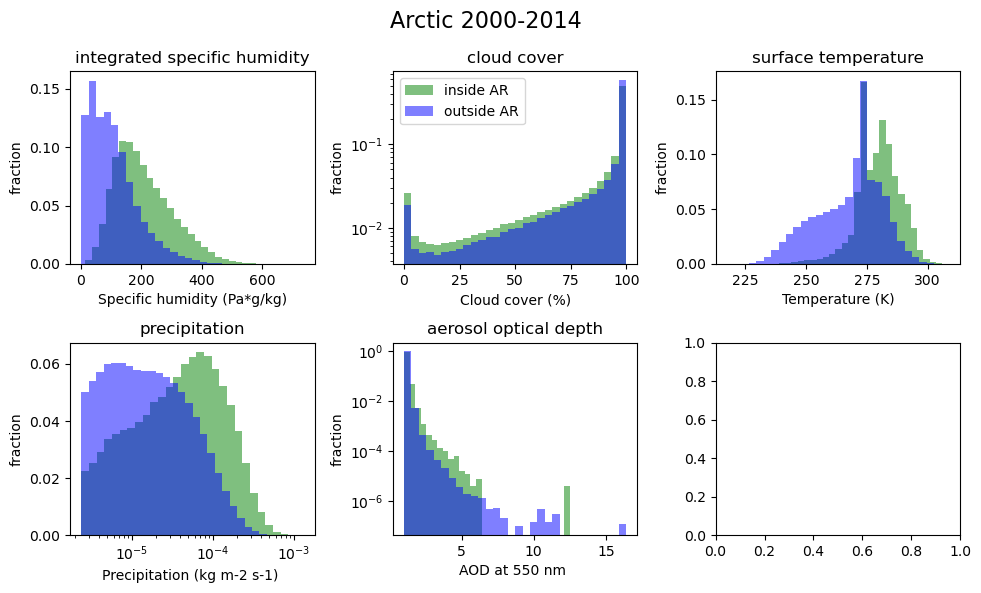

In [31]:
fig, axs = plt.subplots(5, figsize=(10,6))
#axs = axs.flatten()
fig.suptitle('Arctic 2000-2014', fontsize=16)
'''axs[0].hist(mv, weights = np.zeros_like(mv)+1./mv.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins=30)
axs[0].hist(v, weights = np.zeros_like(v)+1./v.size, 
           alpha = 0.5, color = "b", label = "outside AR", bins=30)'''
axs[0].hist(mha, weights = np.zeros_like(mah)+1./mha.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins=30)
axs[0].hist(ha, weights = np.zeros_like(ha)+1./ha.size, 
           alpha = 0.5, color = "b", label = "outside AR", bins=30)
axs[1].hist(mcca, weights = np.zeros_like(mcca)+1./mcca.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins=30)
axs[1].hist(cca,  weights = np.zeros_like(cca)+1./cca.size, 
           alpha = 0.5, color = "b", label = "outside AR", bins=30)
axs[2].hist(mta, weights = np.zeros_like(mta)+1./mta.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins=30)
axs[2].hist(ta, weights = np.zeros_like(ta)+1./ta.size, 
           alpha = 0.5, color = "b", label = "outside AR", bins=30)
axs[3].hist(mpa, weights = np.zeros_like(mpa)+1./mpa.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins=np.logspace(np.log10(mp.min()),np.log10(mp.max()),30))
axs[3].hist(pa, weights = np.zeros_like(pa)+1./pa.size,
           alpha = 0.5, color = "b", label = "outside AR", bins=np.logspace(np.log10(p.min()),np.log10(p.max()),30))
axs[4].hist(maa, weights = np.zeros_like(maa)+1./maa.size, 
           alpha = 0.5, color = "g", label = "inside AR", bins = 30)
axs[4].hist(aa, weights = np.zeros_like(aa)+1./aa.size,
           alpha = 0.5, color = "b", label = "outside AR", bins = 30)
''''axs[0].set_title('integrated wind')
axs[0].set(ylabel = 'fraction', xlabel = 'v (Pa*m/s)')'''
axs[0].set_title('integrated specific humidity')
axs[0].set(ylabel = 'fraction', xlabel = 'Specific humidity (Pa*g/kg)')
axs[1].set_title('cloud cover')
axs[1].set(ylabel = 'fraction', xlabel = 'Cloud cover (%)', yscale ='log')
axs[2].set_title('surface temperature')
axs[2].set(ylabel = 'fraction', xlabel = 'Temperature (K)')
axs[2].legend()
axs[3].set_title('precipitation')
axs[3].set(ylabel = 'fraction', xlabel = 'Precipitation (kg m-2 s-1) ', xscale = 'log')
axs[4].set_title('aerosol optical depth')
axs[4].set(ylabel = 'fraction', xlabel = 'AOD at 550 nm ',  yscale= 'log')
plt.tight_layout()


## Antarctic

In [31]:
# for frequency plots slice for plev >25000 and integrate over plev
mplant =mant.sel(plev=slice(100000, 25000))
plant =amant.sel(plev=slice(100000, 25000)).where(ant['va'] < 0)

'''# wind
mplva =-1*mplant['va'].integrate('plev')
plva =-1*plant['va'].integrate('plev')'''

# humidity
mplh =-1*mplant['hus'].integrate('plev')
plh =-1*plant['hus'].integrate('plev')


In [52]:
'''mv = mplva.values.flatten()
mv = mv[~np.isnan(mv)]
v = plva.values.flatten()
v= v[~np.isnan(v)]'''
mh = mplh.values.flatten()
mh = mh[~np.isnan(mh)]
h = plh.values.flatten()
h = h[~np.isnan(h)]
mcc = mplant['clt'].values.flatten()
mcc = mcc[~np.isnan(mcc)]
cc = plant['clt'].values.flatten()
cc = cc[~np.isnan(cc)]
mt = mplant['tas'].values.flatten()
mt = mt[~np.isnan(mt)]
t = plant['tas'].values.flatten()
t = t[~np.isnan(t)]
ma = mplant['od550aer'].values.flatten()
ma = ma[~np.isnan(ma)]

a = plant['od550aer'].values.flatten()
a = a[~np.isnan(a)]

mp = mplant['pr'].values.flatten()
mp = mp[~np.isnan(mp)]
mp = mp[mp>0.0000024099]
p = plant['pr'].values.flatten()
p = p[~np.isnan(p)]
p = p[p>0.0000024099] # threshold for averaged precipitation in the sahara in the same unit


In [41]:
mp = mp*60*60*24
p = p*60*60*24
mpa = mpa*60*60*24
pa= pa*60*60*24

In [56]:
ma = ma[ma > 0.1]
a = a[a > 0.1]
maa = maa[maa > 0.1]
aa = aa[aa > 0.1]

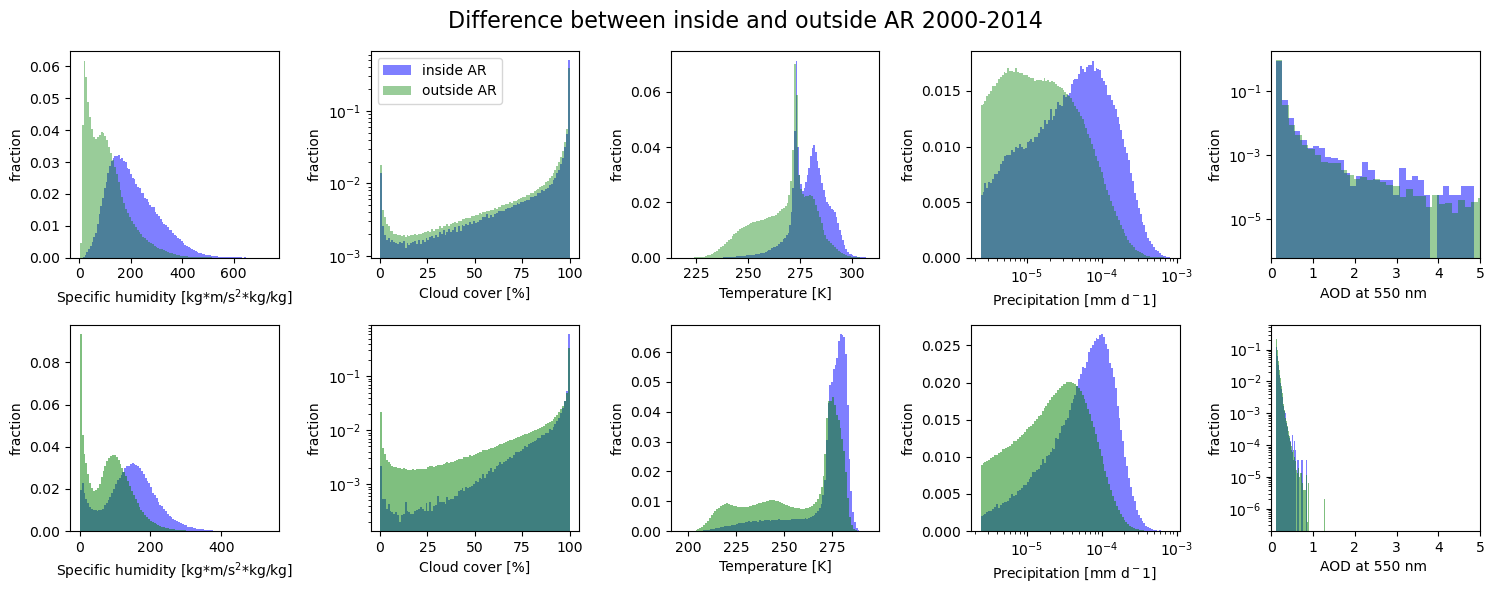

In [62]:
fig, axs = plt.subplots(2,5, figsize=(15,6))
axs = axs.flatten()
fig.suptitle('Difference between inside and outside AR 2000-2014', fontsize=16)

axs[5].hist(mh, weights = np.zeros_like(mh)+1./mh.size, 
           alpha = 0.5, color = "b", label = "inside AR", bins=100)
axs[5].hist(h, weights = np.zeros_like(h)+1./h.size, 
           alpha = 0.5, color = "g", label = "outside AR", bins=100)
axs[6].hist(mcc, weights = np.zeros_like(mcc)+1./mcc.size, 
           alpha = 0.5, color = "b", label = "inside AR", bins=100)
axs[6].hist(cc,  weights = np.zeros_like(cc)+1./cc.size, 
           alpha = 0.5, color = "g", label = "outside AR", bins=100)
axs[7].hist(mt, weights = np.zeros_like(mt)+1./mt.size, 
           alpha = 0.5, color = "b", label = "inside AR", bins=100)
axs[7].hist(t, weights = np.zeros_like(t)+1./t.size, 
           alpha = 0.5, color = "g", label = "outside AR", bins=100)
axs[8].hist(mp, weights = np.zeros_like(mp)+1./mp.size, 
           alpha = 0.5, color = "b", label = "inside AR", bins=np.logspace(np.log10(mp.min()),np.log10(mp.max()),100))
axs[8].hist(p, weights = np.zeros_like(p)+1./p.size,
           alpha = 0.5, color = "g", label = "outside AR", bins=np.logspace(np.log10(p.min()),np.log10(p.max()),100))
axs[9].hist(ma, weights = np.zeros_like(ma)+1./ma.size, 
           alpha = 0.5, color = "b", label = "inside AR", bins = 100)
axs[9].hist(a, weights = np.zeros_like(a)+1./a.size,
           alpha = 0.5, color = "g", label = "outside AR", bins = 100)

#axs[0].set_title('Antarctic')
axs[0].set(ylabel = 'fraction', xlabel = 'Specific humidity [kg*m/s$^2$*kg/kg]')
#axs[1].set_title('cloud cover')
axs[1].set(ylabel = 'fraction', xlabel = 'Cloud cover [%]', yscale ='log')
#axs[2].set_title('surface temperature')
axs[2].set(ylabel = 'fraction', xlabel = 'Temperature [K]')
#axs[3].set_title('precipitation')
axs[3].set(ylabel = 'fraction', xlabel = 'Precipitation [mm d$^-1$] ', xscale = 'log')
#axs[4].set_title('aerosol optical depth')
axs[4].set(ylabel = 'fraction', xlabel = 'AOD at 550 nm ', xlim=(0,5), yscale = 'log')

axs[0].hist(mha, weights = np.zeros_like(mha)+1./mha.size, 
           alpha = 0.5, color = "b", label = "inside AR", bins=100)
axs[0].hist(ha, weights = np.zeros_like(ha)+1./ha.size, 
           alpha = 0.4, color = "g", label = "outside AR", bins=100)
axs[1].hist(mcca, weights = np.zeros_like(mcca)+1./mcca.size, 
           alpha = 0.5, color = "b", label = "inside AR", bins=100)
axs[1].hist(cca,  weights = np.zeros_like(cca)+1./cca.size, 
           alpha = 0.4, color = "g", label = "outside AR", bins=100)
axs[2].hist(mta, weights = np.zeros_like(mta)+1./mta.size, 
           alpha = 0.5, color = "b", label = "inside AR", bins=100)
axs[2].hist(ta, weights = np.zeros_like(ta)+1./ta.size, 
           alpha = 0.4, color = "g", label = "outside AR", bins=100)
axs[3].hist(mpa, weights = np.zeros_like(mpa)+1./mpa.size, 
           alpha = 0.5, color = "b", label = "inside AR", bins=np.logspace(np.log10(mp.min()),np.log10(mp.max()),100))
axs[3].hist(pa, weights = np.zeros_like(pa)+1./pa.size,
           alpha = 0.4, color = "g", label = "outside AR", bins=np.logspace(np.log10(p.min()),np.log10(p.max()),100))
axs[4].hist(maa, weights = np.zeros_like(maa)+1./maa.size, 
           alpha = 0.5, color = "b", label = "inside AR", bins = 100)
axs[4].hist(aa, weights = np.zeros_like(aa)+1./aa.size,
           alpha = 0.4, color = "g", label = "outside AR", bins = 100)
#axs[1].set_title('Arctic')
axs[5].set(ylabel = 'fraction', xlabel = 'Specific humidity [kg*m/s$^2$*kg/kg]')
#axs[6].set_title('cloud cover')
axs[6].set(ylabel = 'fraction', xlabel = 'Cloud cover [%]', yscale ='log')
#axs[7].set_title('surface temperature')
axs[7].set(ylabel = 'fraction', xlabel = 'Temperature [K]')
#axs[8].set_title('precipitation')
axs[8].set(ylabel = 'fraction', xlabel = 'Precipitation [mm d$^-1$] ', xscale = 'log')
#axs[9].set_title('aerosol optical depth')
axs[9].set(ylabel = 'fraction', xlabel = 'AOD at 550 nm ', xlim=(0,5), yscale = 'log')
axs[1].legend()
plt.tight_layout()
plt.savefig('in_out_AR.png')